In [436]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import random
import sys
import seaborn as sns


directory = os.path.join(os.getcwd(), '../../../../Service\service\eeg')
# print(os.path.abspath(directory))

sys.path.append(directory)
from eeg_data_check import Filter, FFTDataCheck

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1460\2320323734.py:12: SyntaxWarning: invalid escape sequence '\s'
  directory = os.path.join(os.getcwd(), '../../../../Service\service\eeg')


In [437]:
sample_seconds = 0.9*1  # Each sample window seconds
sample_freq = 250 # 250hz 

sample_length = int(sample_freq * sample_seconds)


print(f"sample length: {sample_length}")

sample length: 225


In [438]:
positive_subject_dir = './healthy_20240612'
df= pd.read_csv('./healthy_20240612/label_SDS.csv')

In [439]:
excluded_subjects = ['A14','A27','A06']
df = df[~df['ID'].isin(excluded_subjects)]

In [440]:
df.columns

Index(['ID', '1. I feel down-hearted and blue.',
       '2. Morning is when I feel the best.',
       '3. I have crying spells or feel like it.',
       '4. I have trouble sleeping at night.',
       '5. I eat as much as I used to.', '6. I still enjoy sex.',
       '7. I notice that I am losing weight.',
       '8. I have trouble with constipation.',
       '9. My heart beats faster than usual.',
       '10. I get tired for no reason.',
       '11. My mind is as clear as it used to be.',
       '12. I find it easy to do the things I used to.',
       '13. I am restless and can??t keep still.',
       '14. I feel hopeful about the future.',
       '15. I am more irritable than usual.',
       '16. I find it easy to make decisions.',
       '17. I feel that I am useful and needed.',
       '18. My life is pretty full.',
       '19. I feel that others would be better off if I were dead.',
       '20. I still enjoy the things I used to do.', 'vitality'],
      dtype='object')

In [441]:
emotion = 'vitality'

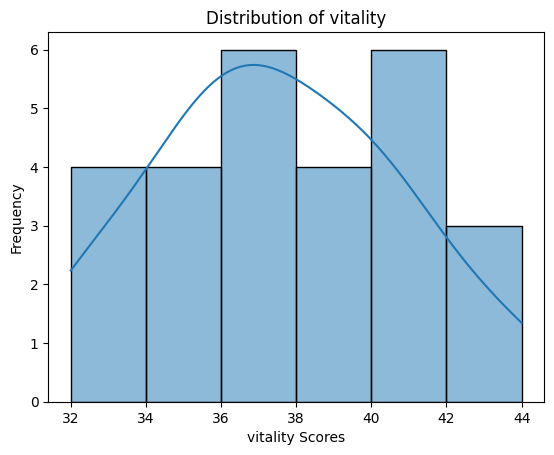

In [442]:
sns.histplot(data=df, x=emotion, kde=True)
plt.title('Distribution of vitality')
plt.xlabel('vitality Scores')
plt.ylabel('Frequency')
plt.show()


In [443]:
negative_subjects = df[df[emotion]< 40]['ID'].to_list()
positive_subjects = df[df[emotion]>= 40
                       ]['ID'].to_list()


In [444]:
random.shuffle(positive_subjects)
random.shuffle(negative_subjects)

print(f"positive subjects count: {len(positive_subjects)}", positive_subjects)
print(f"negative subjects count: {len(negative_subjects)}", negative_subjects)

positive subjects count: 9 ['A03', 'A25', 'A09', 'A04', 'A11', 'A15', 'A07', 'A29', 'A21']
negative subjects count: 18 ['A12', 'A08', 'A23', 'A10', 'A17', 'A02', 'A22', 'A20', 'A26', 'A30', 'A05', 'A28', 'A18', 'A13', 'A16', 'A24', 'A01', 'A19']


In [445]:

train_positive_subjects = positive_subjects[0: len(positive_subjects)-4]
test_positive_subjects = positive_subjects[len(positive_subjects)-4::]

train_negative_subjects = negative_subjects[0:len(negative_subjects)-4]
test_negative_subjects = negative_subjects[len(negative_subjects)-4::]

print("train positive subjects: ", train_positive_subjects)
print("test positive subjects: ", test_positive_subjects)

print("train negative subjects: ", train_negative_subjects)
print("test negative subjects: ", test_negative_subjects)

train positive subjects:  ['A03', 'A25', 'A09', 'A04', 'A11']
test positive subjects:  ['A15', 'A07', 'A29', 'A21']
train negative subjects:  ['A12', 'A08', 'A23', 'A10', 'A17', 'A02', 'A22', 'A20', 'A26', 'A30', 'A05', 'A28', 'A18', 'A13']
test negative subjects:  ['A16', 'A24', 'A01', 'A19']


In [446]:
print(len(train_negative_subjects),len(train_positive_subjects))

14 5


In [447]:
data_filter = FFTDataCheck()

In [448]:
def read_json_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            # print("reading json file: ", file_path)
            data = json.load(file)
        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def _get_samples(base_dir: str, target_subjects: list, label: int, data_aug: int=1):
    samples_ret = []
    for subject in target_subjects:
        files = os.listdir(base_dir)
        for file in files:
            if file.startswith(subject) and "EEG" in file:
                file_path = os.path.join(base_dir, file)
                json_data = read_json_file(file_path)
                left_wave_all, right_wave_all = [], []
                for raw_data in json_data['ProcessedDatas']:
                    left_wave = raw_data['LeftWave']
                    right_wave = raw_data['RightWave']

                    left_wave_all += left_wave
                    right_wave_all += right_wave


                if(len(left_wave_all) != len(right_wave_all)):
                    raise("error!!! left wave count not equal right wave count")
                
                samples = []
                step = sample_length // data_aug

                print(f"step: {step}")
                for idx in range(0, len(left_wave_all), step):
                        # print("idx: ", idx)
                        sub_left_wave = left_wave_all[idx:idx+sample_length]
                        sub_right_wave = right_wave_all[idx:idx+sample_length]
                        if len(sub_left_wave) != sample_length or len(sub_right_wave) != sample_length:
                            continue

                        left_valid = data_filter.is_valid(sub_left_wave)
                        right_valid = data_filter.is_valid(sub_right_wave)

                        print("left_valid: ", left_valid, " right_valid: ", right_valid)
                        if left_valid and right_valid:
                            left_fft = np.abs(np.fft.fft(sub_left_wave))[:64]
                            left_fft = left_fft / np.sum(left_fft)

                            right_fft = np.abs(np.fft.fft(sub_right_wave))[:64]
                            right_fft = right_fft / np.sum(right_fft)

                            feat = np.concatenate([left_fft, right_fft], axis=0)
                            # print(len(feat))
                            samples.append((subject, feat, label))
                samples_ret += samples
                print(f"read file: {file_path} left_wave_all: {len(left_wave_all)} sample length: {sample_length} data aug: {data_aug} step: {step}, samples count: {len(samples)}")
                
    return samples_ret


def get_train_negative_samples():
    return _get_samples(base_dir=positive_subject_dir, target_subjects=train_negative_subjects, label=0,data_aug=1)

def get_test_negative_samples():
    return _get_samples(base_dir=positive_subject_dir, target_subjects=test_negative_subjects, label=0)


def get_train_positive_samples():
    return _get_samples(base_dir=positive_subject_dir, target_subjects=train_positive_subjects, label=1, data_aug =3)

def get_test_positive_samples():
    return _get_samples(base_dir=positive_subject_dir, target_subjects=test_positive_subjects, label=1)


train_negative_samples = get_train_negative_samples()
test_negative_samples = get_test_negative_samples()

train_positive_samples = get_train_positive_samples()
test_positive_samples = get_test_positive_samples()


step: 225
left_valid:  False  right_valid:  False
left_valid:  False  right_valid:  False
left_valid:  False  right_valid:  False
left_valid:  False  right_valid:  False
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid:  True
left_valid:  True  right_valid: 

In [449]:
print(f"len(train_negative_samples): {len(train_negative_samples)}")

len(train_negative_samples): 9762


In [450]:
print("train_negative_samples count: ", len(train_negative_samples))
print("train_positive_samples count: ", len(train_positive_samples))

print("test_negative_samples count: ", len(test_negative_samples))
print("test_positive_samples count: ", len(test_positive_samples))


MIN = min(len(test_negative_samples), len(test_positive_samples))
test_negative_samples = test_negative_samples[0:MIN]
test_positive_samples = test_positive_samples[0:MIN]

print("\nAfter truncate: ")
print("test_negative_samples count: ", len(test_negative_samples))
print("test_positive_samples count: ", len(test_positive_samples))


train_negative_samples count:  9762
train_positive_samples count:  10486
test_negative_samples count:  3173
test_positive_samples count:  2580

After truncate: 
test_negative_samples count:  2580
test_positive_samples count:  2580


In [451]:
sample_folder = './samples'
if not os.path.exists(sample_folder):
    os.makedirs(sample_folder)

with open(os.path.join(sample_folder, 'train_negative_samples.pkl'), 'wb') as f:
    pickle.dump(train_negative_samples, f)

with open(os.path.join(sample_folder, 'train_positive_samples.pkl'), 'wb') as f:
    pickle.dump(train_positive_samples, f)

with open(os.path.join(sample_folder, 'test_negative_samples.pkl'), 'wb') as f:
    pickle.dump(test_negative_samples, f)

with open(os.path.join(sample_folder, 'test_positive_samples.pkl'), 'wb') as f:
    pickle.dump(test_positive_samples, f)


In [452]:
print(len(train_negative_samples[0][0]))
print(len(train_positive_samples[0][0]))
print(len(test_negative_samples[0][0]))
print(len(test_positive_samples[0][0]))

3
3
3
3
